Dataset Shape: (2861, 11)

First 5 rows:


,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,17.02.2000,0.330,2.77,12.0,12.30,9.50,0.057,154.0,0.454,289.5
1,1,11.05.2000,0.044,3.00,51.6,14.61,17.75,0.034,352.0,0.090,1792.0
2,1,11.09.2000,0.032,2.10,24.5,9.87,13.80,0.173,416.0,0.200,2509.0
3,1,13.12.2000,0.170,2.23,35.6,12.40,17.13,0.099,275.2,0.377,1264.0
4,1,02.03.2001,0.000,3.03,48.8,14.69,10.00,0.065,281.6,0.134,1462.0



Data Types:
id             int64
date          object
NH4          float64
BSK5         float64
Suspended    float64
O2           float64
NO3          float64
NO2          float64
SO4          float64
PO4          float64
CL           float64
dtype: object

Missing Values:
id            0
date          0
NH4           3
BSK5          1
Suspended    16
O2            3
NO3           1
NO2           3
SO4          49
PO4          28
CL           49
dtype: int64

Descriptive Statistics:


,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
count,2861.000000,2861,2858.000000,2860.000000,2845.000000,2858.000000,2860.000000,2858.000000,2812.000000,2833.000000,2812.000000
mean,12.397064,2010-05-02 22:53:33.701502976,0.758734,4.316182,12.931905,9.508902,4.316846,0.246128,59.362313,0.418626,93.731991
min,1.000000,2000-01-10 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000
25%,8.000000,2005-03-10 00:00:00,0.080000,2.160000,6.000000,7.092500,1.390000,0.030000,27.052500,0.130000,26.800000
50%,14.000000,2010-06-04 00:00:00,0.220000,3.800000,10.000000,8.995000,2.800000,0.059000,37.800000,0.270000,33.900000
75%,16.000000,2015-08-11 00:00:00,0.500000,5.800000,15.000000,11.520000,5.582500,0.125750,64.640000,0.470000,45.607500
max,22.000000,2021-04-07 00:00:00,39.427000,50.900000,595.000000,90.000000,133.400000,109.000000,3573.400000,13.879000,5615.280000
std,6.084226,NaN,2.486247,2.973997,16.543097,4.428260,6.881188,2.182777,96.582641,0.771326,394.512184


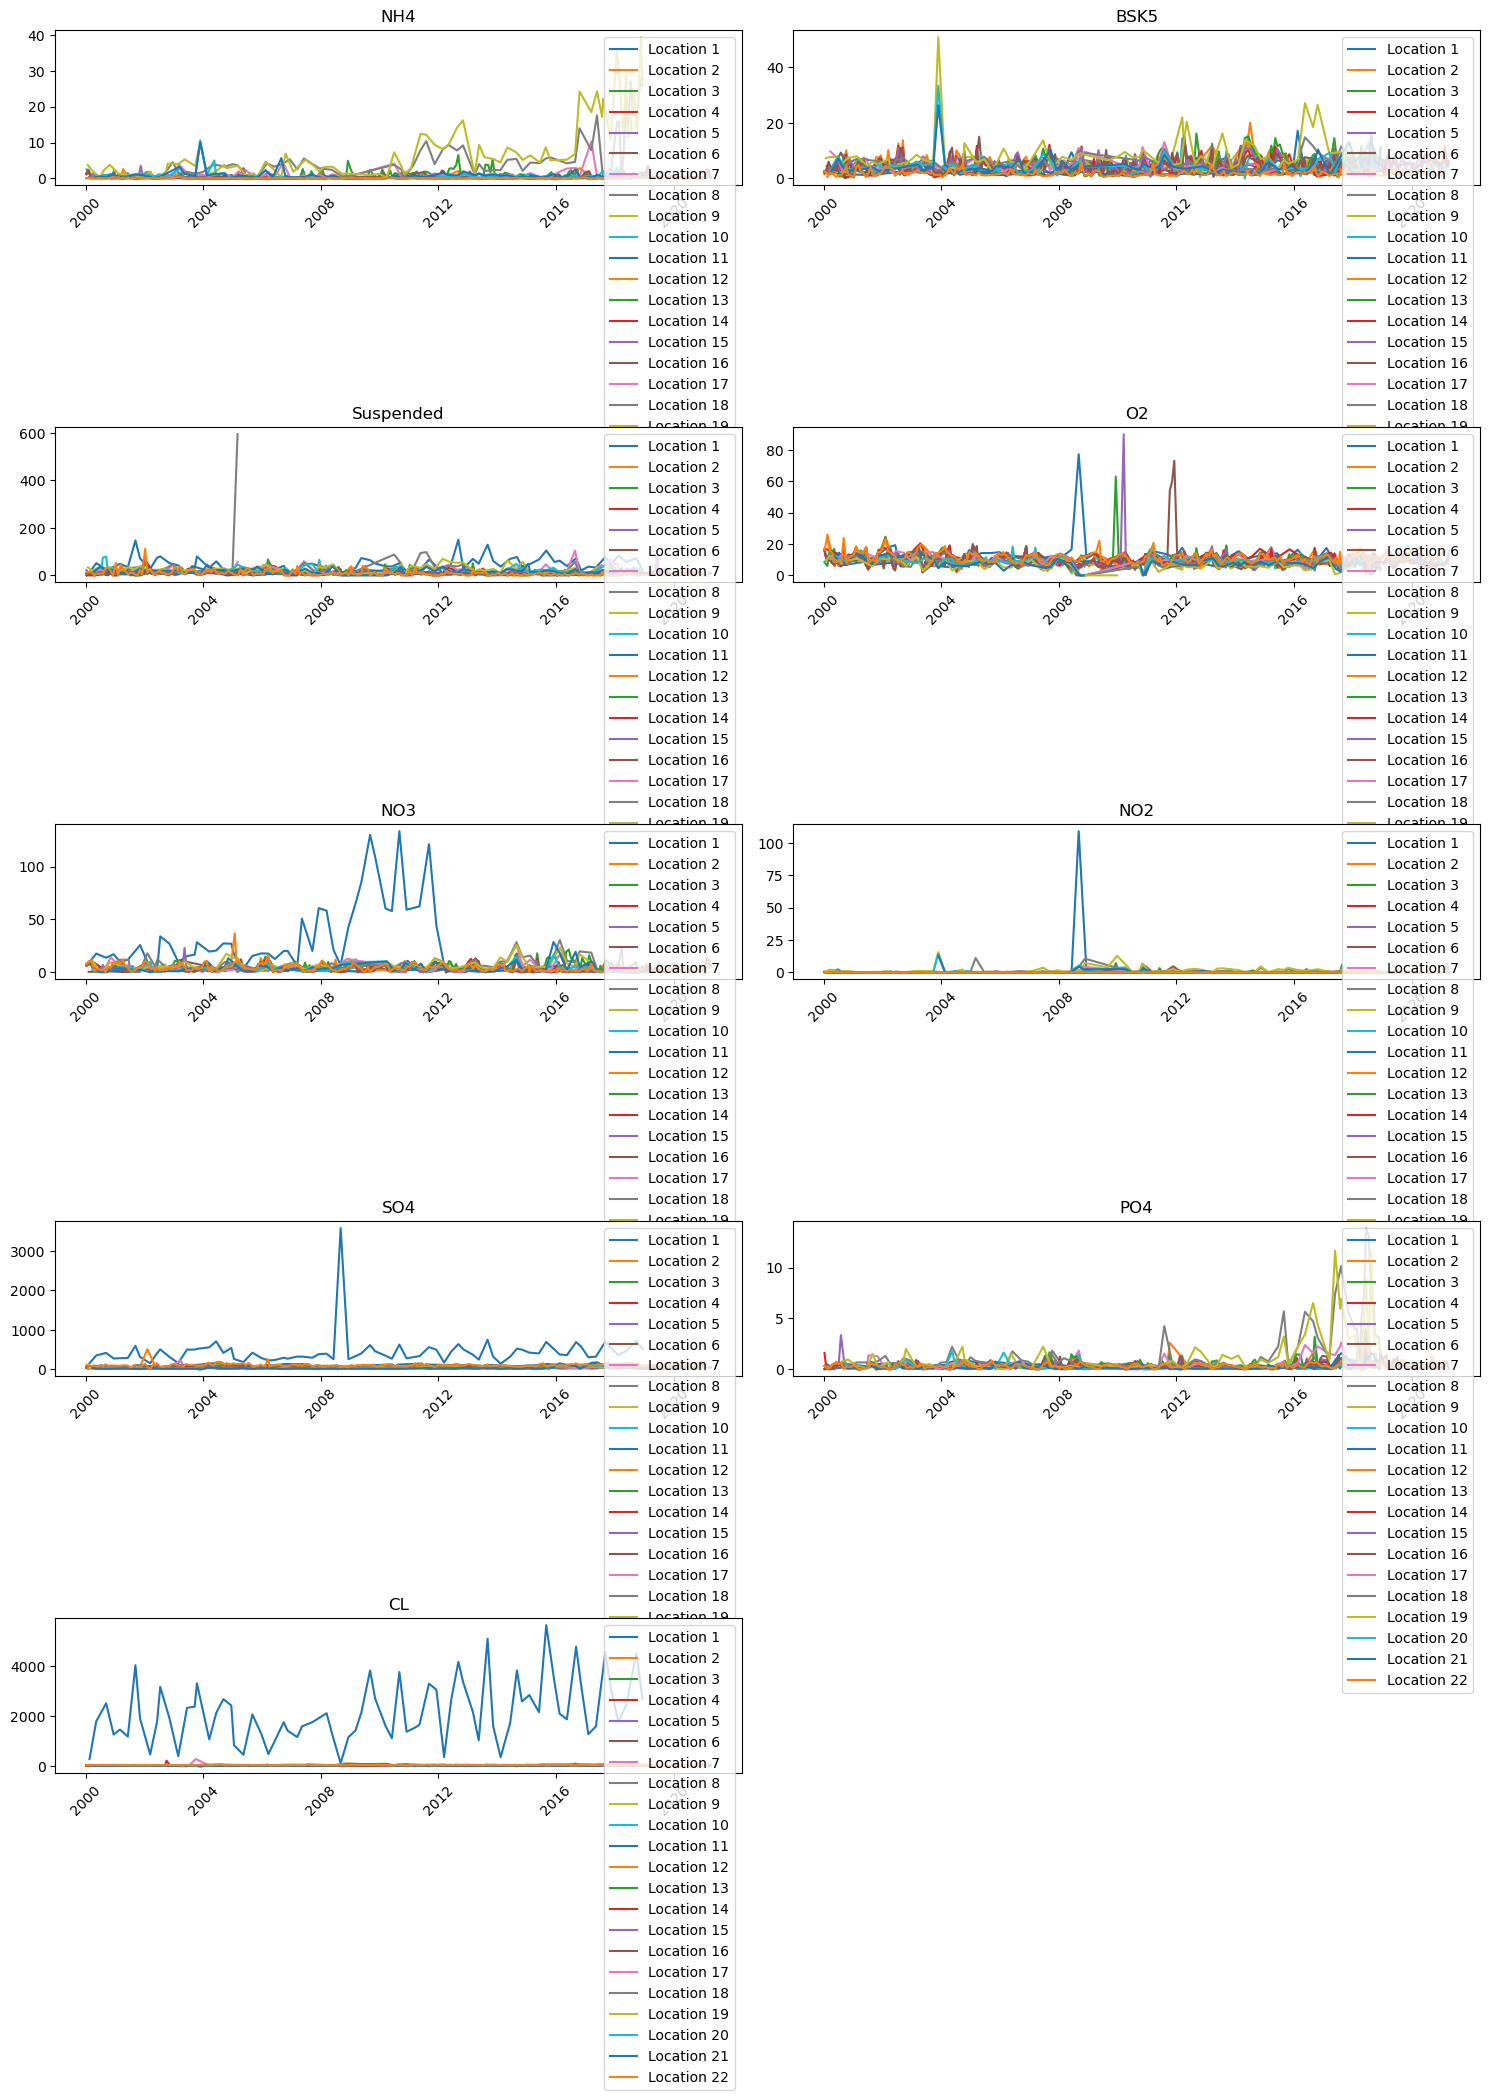

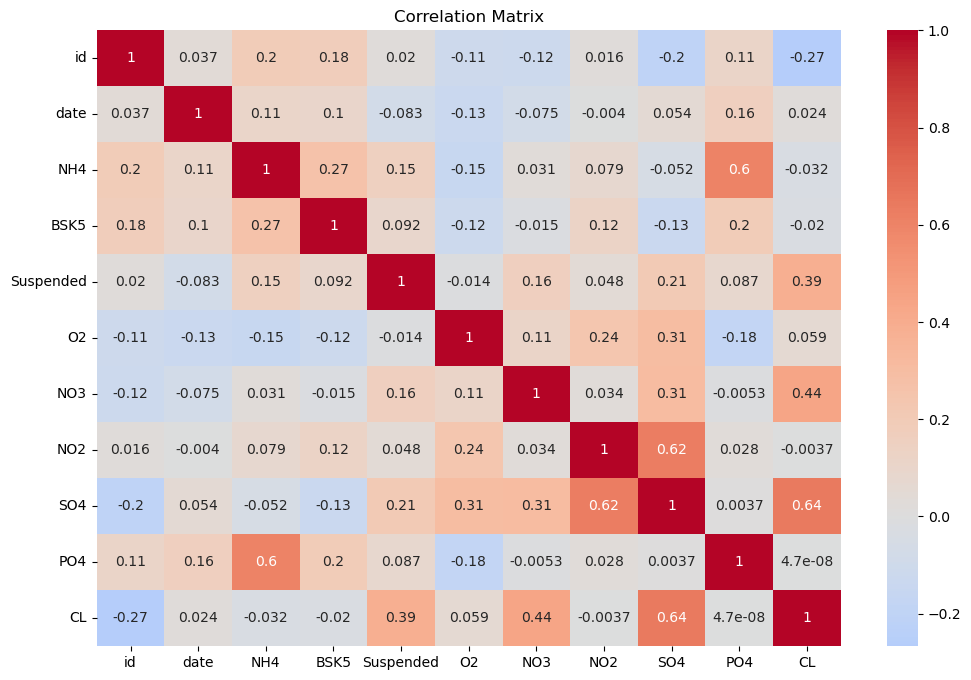

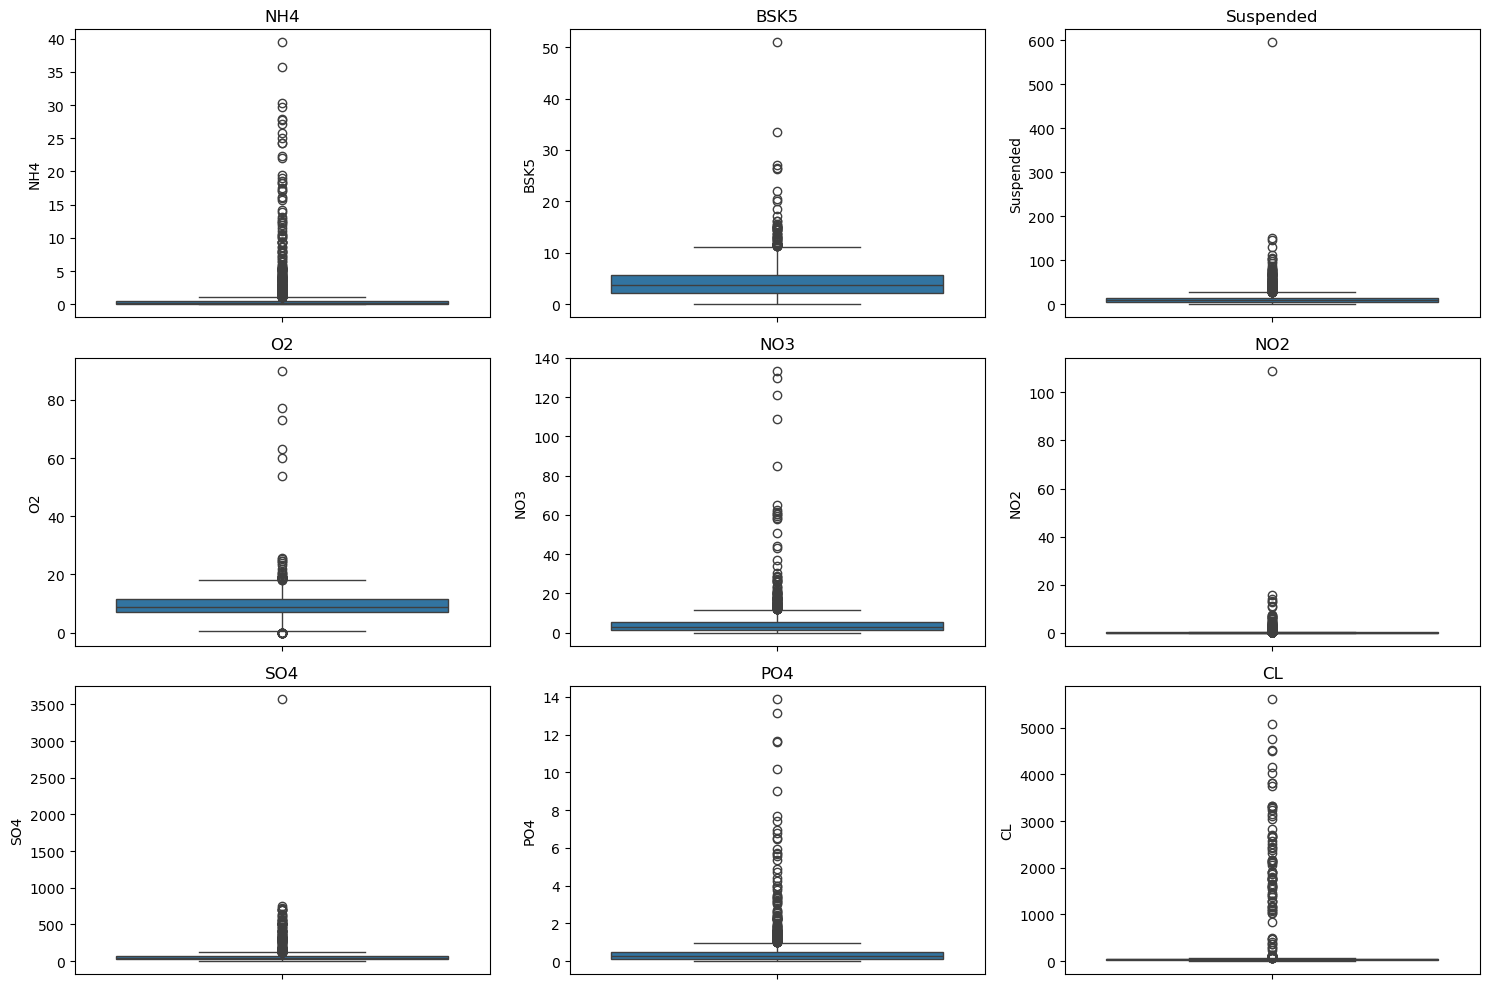

ValueError: x must have 2 complete cycles requires 24 observations. x only has 0 observation(s)

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('sample data.csv', sep=';')

# Data Exploration
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
display(data.head())
print("\nData Types:")
print(data.dtypes)
print("\nMissing Values:")
print(data.isnull().sum())

# Convert date to datetime format
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

# Basic Statistics
print("\nDescriptive Statistics:")
display(data.describe())

# Data Visualization
plt.figure(figsize=(15, 20))

# Time series plot for each parameter by location
for i, col in enumerate(['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']):
    plt.subplot(5, 2, i+1)
    for location in data['id'].unique():
        subset = data[data['id'] == location]
        plt.plot(subset['date'], subset[col], label=f'Location {location}')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.legend()
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Box plots to identify outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Feature Engineering
# Extract year, month, and day from date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Handle missing values (if any)
data.fillna(data.median(), inplace=True)

# Check for and remove duplicates
data.drop_duplicates(inplace=True)

# Outlier treatment using IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_cols = ['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']
data = remove_outliers(data, numerical_cols)

# Time Series Analysis for a specific location and parameter
location = 1
parameter = 'O2'
subset = data[data['id'] == location][['date', parameter]]
subset.set_index('date', inplace=True)

# Decompose time series
result = seasonal_decompose(subset, model='additive', period=12)
result.plot()
plt.suptitle(f'Time Series Decomposition for {parameter} at Location {location}')
plt.tight_layout()
plt.show()

# Prepare data for modeling
X = data.drop(['id', 'date', 'O2'], axis=1)  # Using O2 as target for this example
y = data['O2']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality reduction with PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Reduced number of features: {X_train_pca.shape[1]}")

# Model Training and Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    
    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        if X_train.shape[1] > 10:  # If using original features
            importances = model.feature_importances_
            indices = np.argsort(importances)[-10:]  # Top 10 features
            plt.title('Top 10 Feature Importances')
            plt.barh(range(10), importances[indices], align='center')
            plt.yticks(range(10), X.columns[indices])
        else:  # If using PCA components
            importances = model.feature_importances_
            plt.title('Feature Importances (PCA Components)')
            plt.bar(range(len(importances)), importances)
        plt.tight_layout()
        plt.show()
    
    return rmse, r2

# Initialize models
models = [
    LinearRegression(),
    RandomForestRegressor(random_state=42),
    SVR()
]

# Evaluate each model
results = []
for model in models:
    rmse, r2 = evaluate_model(model, X_train_pca, X_test_pca, y_train, y_test)
    results.append({
        'Model': model.__class__.__name__,
        'RMSE': rmse,
        'R2 Score': r2
    })

# Display results
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
display(results_df)

# Hyperparameter tuning for the best model (Random Forest in this case)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_pca, y_train)

print("\nBest Parameters:", grid_search.best_params_)

# Evaluate the best model
best_rf = grid_search.best_estimator_
rmse, r2 = evaluate_model(best_rf, X_train_pca, X_test_pca, y_train, y_test)

# Predictions vs Actual plot
y_pred = best_rf.predict(X_test_pca)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Time series forecast (using last 20% of data for testing)
location_data = data[data['id'] == 1].sort_values('date')
train_size = int(len(location_data) * 0.8)
train, test = location_data.iloc[:train_size], location_data.iloc[train_size:]

# Prepare time series data
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 3
train_X, train_Y = create_dataset(train['O2'].values, look_back)
test_X, test_Y = create_dataset(test['O2'].values, look_back)

# Train time series model
ts_model = RandomForestRegressor(random_state=42)
ts_model.fit(train_X, train_Y)

# Make predictions
train_predict = ts_model.predict(train_X)
test_predict = ts_model.predict(test_X)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(train_Y, train_predict))
test_rmse = np.sqrt(mean_squared_error(test_Y, test_predict))
print(f"\nTime Series Model RMSE - Train: {train_rmse:.4f}, Test: {test_rmse:.4f}")

# Plot time series predictions
plt.figure(figsize=(15, 6))
plt.plot(location_data['date'], location_data['O2'], label='Actual')
plt.plot(train['date'].iloc[look_back+1:], train_predict, label='Train Predictions')
plt.plot(test['date'].iloc[look_back+1:], test_predict, label='Test Predictions')
plt.legend()
plt.title('Time Series Prediction of O2 Levels')
plt.xticks(rotation=45)
plt.show()